### Generate adata from supplemental data from Hill et al. 2022

https://doi.org/10.1038/s41586-022-04989-3

Control cardiac tissue samples from donors were collected from the University of Kentucky (Samples UK1/FC3CB and UK2/3B62D) and Washington University in St Louis (LV198/RV198/13–198 and RV325/13235)

All scRNA-seq and snRNA-seq were performed by using the 10X Genomics platform. Cells or nuclei were isolated as described earlier and were loaded into the 10X Genomics Chromium Controller to obtain the gel beads in emulsion. The sequencing libraries were then prepared according to the 10X genomics protocol for Single Cell 3' Reagents Kit v3.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
from collections import Counter
import re
import scanpy.external as sce

In [2]:
def preprocess_adata(adata, donor_key, leiden_resolution):
    '''
    Performs: 
    1. library size normalization and log scaling
    2. identification of top 2K highly variable genes, 
    3. Principal component analysis
    4. Harmony integration
    5. Neighbor neighbors computation in Harmony integration embedding
    6. Leiden clustering 
    
    Parameters:
    adata (AnnData): adata object before preprocessing
    donor_key: the column in adata.obs that corresponds to the donor information (should be 'donor_id')
    leiden_resolution: resolution for leiden clustering, higher means more clusters will be detected

    Returns:
    adata: Postprocessed adata
    '''
    # Normalizing to median total counts
    sc.pp.normalize_total(adata)
    # Logarithmize the data
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key=donor_key)
    sc.tl.pca(adata)
    sce.pp.harmony_integrate(adata, donor_key)
    sc.pp.neighbors(adata, use_rep = "X_pca_harmony")
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=donor_key, size=2)
    sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution = 0.5)
    return(adata)

### Load in the full Hill adata

In [3]:
adata = sc.read_h5ad("01_Hill_LV_adata.h5ad")

### Filter to diseased

In [4]:
# filter to those with a procedure performed (diseased)
adata = adata[~adata.obs.procedure.isnull(), :].copy()
adata

AnnData object with n_obs × n_vars = 103033 × 29266
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'labID', 'procedure', 'age', 'gender', 'echoEF', 'vers10X', 'diagnosis', 'ageCont', 'region', 'batch_indices', 'percent_mt', 'ClinicalRank', 'DEid', 'MainCellType', 'Cluster', 'labID2', 'colors', 'Diagnosis', 'patientID', 'cell_id', 'biosample_id', 'donor_id', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'sex', 'library_preparation_protocol__ontology_label'
    layers: 'counts'

In [5]:
metadata = adata.obs
Counter(metadata.donor_id)

Counter({'P86': 21850,
         'P40': 16321,
         'P75': 15070,
         'P64': 14055,
         'P36': 12906,
         'P33': 7213,
         'P8': 6995,
         'P28': 6195,
         'P26': 2428})

#### Perform some cleaning up of the metadata

In [6]:
metadata = metadata[["donor_id", "age", "sex", "MainCellType", "library_preparation_protocol__ontology_label"]]
Counter(metadata.donor_id)

Counter({'P86': 21850,
         'P40': 16321,
         'P75': 15070,
         'P64': 14055,
         'P36': 12906,
         'P33': 7213,
         'P8': 6995,
         'P28': 6195,
         'P26': 2428})

In [7]:
metadata['region'] = "LV"
metadata = metadata.rename(columns = {'library_preparation_protocol__ontology_label': 'technology',
                                      'MainCellType': 'cell_type', 
                                      'procedure': 'disease'})
metadata['technology'] = '3prime-v3'
metadata['cell_or_nuclei'] = 'Nuclei'
metadata['study'] = 'Hill 2022'

/mnt/data1/william/tmp/ipykernel_3638616/1449708366.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata['region'] = "LV"


#### Clean up the ages

In [8]:
Counter(metadata.age)

Counter({'11y_3m_12d': 21850,
         '4y_4m_20d': 16321,
         '16y_2m_25d': 15070,
         '3y_3m_17d': 14055,
         '17y_3m_13d': 12906,
         '0y_7m_3d': 7213,
         '0y_2m_3d': 6995,
         '0y_8m_9d': 6195,
         '0y_3m_3d': 2428})

In [9]:
metadata['age_revised'] = metadata['age'].map(
    {
        '11y_3m_12d': 11,
        '4y_4m_20d': 4,
        '16y_2m_25d': 16,
        '3y_3m_17d': 3,
        '17y_3m_13d': 17,
        '0y_7m_3d': 0,
        '0y_8m_9d': 0, 
        '0y_2m_3d': 0,
        '0y_3m_3d': 0,
    }
)
metadata.age_revised = metadata.age_revised.astype(int)

In [10]:
Counter(metadata.age_revised)

Counter({0: 22831, 11: 21850, 4: 16321, 16: 15070, 3: 14055, 17: 12906})

In [11]:
metadata['age'] = metadata['age_revised']

In [12]:
Counter(metadata.donor_id)

Counter({'P86': 21850,
         'P40': 16321,
         'P75': 15070,
         'P64': 14055,
         'P36': 12906,
         'P33': 7213,
         'P8': 6995,
         'P28': 6195,
         'P26': 2428})

In [13]:
adata.obs = metadata

### Perform QC filtering

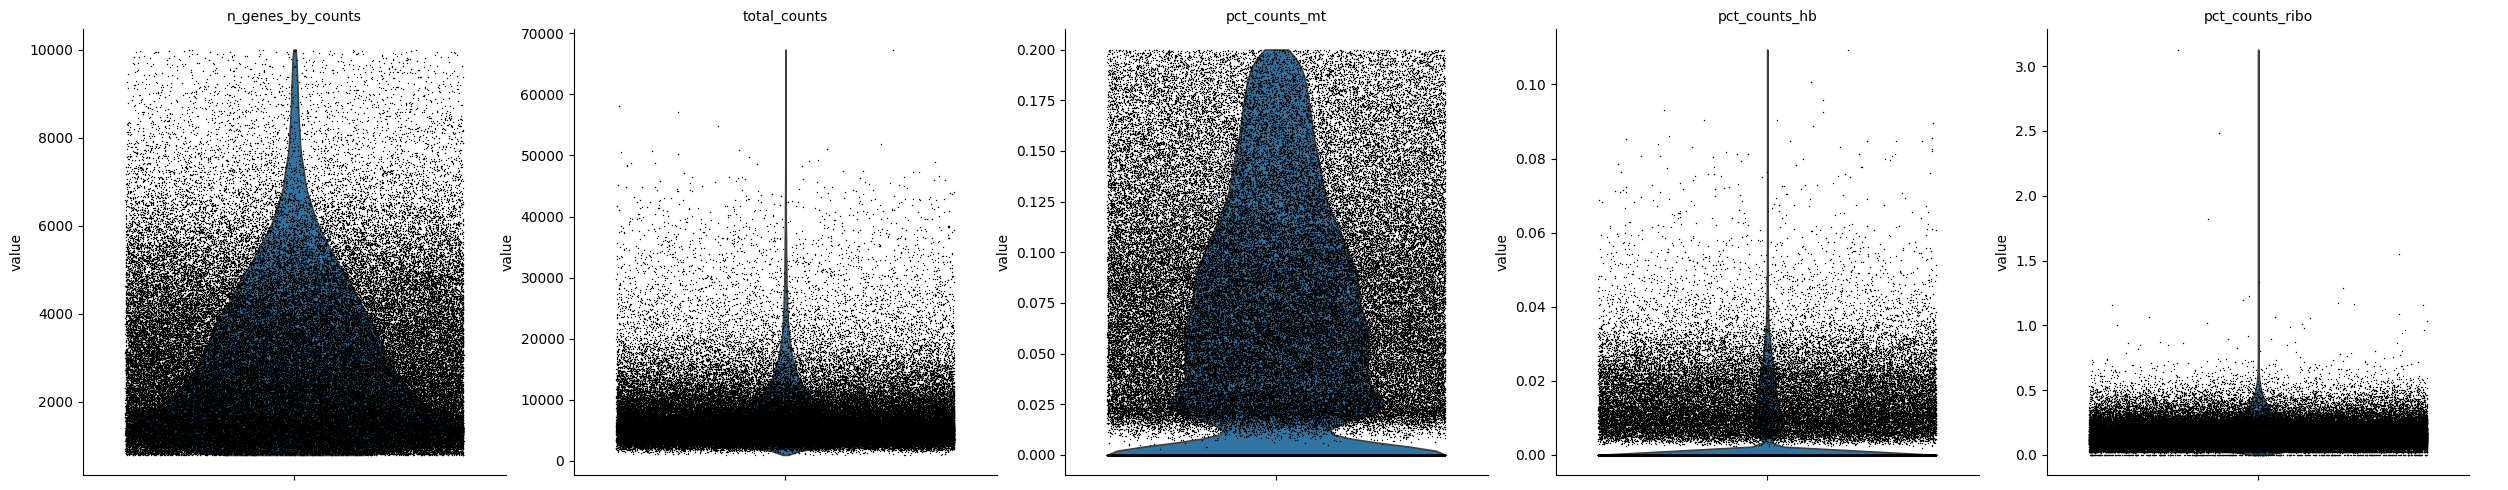

Filtered out 0 cells
CPU times: user 40 s, sys: 34.7 s, total: 1min 14s
Wall time: 23.4 s


In [14]:
%%time 

adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_hb", "pct_counts_ribo"], 
             jitter=0.4,multi_panel=True,)

# filter the cells out that are above the specified thresholds for mitochondrial, ribosomal, and hemoglobin reads
mito_threshold = 5.0
ribo_threshold = 5.0
hb_threshold = 5.0 

adata_size_before = adata.shape[0]

adata = ( adata[(adata.obs.pct_counts_mt <= mito_threshold) &
                (adata.obs.pct_counts_ribo <= ribo_threshold) &
                (adata.obs.pct_counts_hb <= hb_threshold), :].copy()
        )

adata_size_after = adata.shape[0]
num_filtered = adata_size_before - adata_size_after
print(f"Filtered out {num_filtered} cells")

In [15]:
%%time
donor_key = "donor_id"
# predict the doublets with scrublet
sc.pp.scrublet(adata, batch_key = donor_key)
num_doublets = adata[adata.obs.predicted_doublet == True].shape[0]
# filter out the doublets
adata = adata[adata.obs.predicted_doublet == False, :].copy()
print(f"Filtered out {num_doublets} likely doublets")

Filtered out 7982 likely doublets
CPU times: user 17min 15s, sys: 11min 19s, total: 28min 34s
Wall time: 11min 43s


2024-11-23 16:14:20,593 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-11-23 16:14:26,249 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-11-23 16:14:26,765 - harmonypy - INFO - Iteration 1 of 10
2024-11-23 16:15:04,841 - harmonypy - INFO - Iteration 2 of 10
2024-11-23 16:15:39,841 - harmonypy - INFO - Iteration 3 of 10
2024-11-23 16:15:52,103 - harmonypy - INFO - Converged after 3 iterations


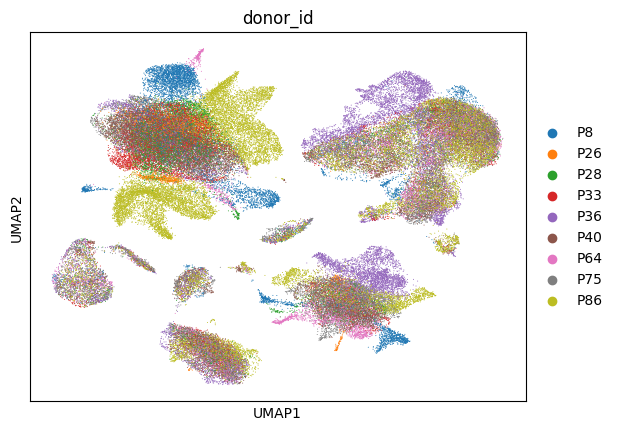

CPU times: user 22min 54s, sys: 1h 24min 29s, total: 1h 47min 24s
Wall time: 3min 30s


In [16]:
%%time
LEIDEN_RES = 0.5
adata = preprocess_adata(adata = adata, 
                         donor_key = "donor_id",
                         leiden_resolution = LEIDEN_RES)

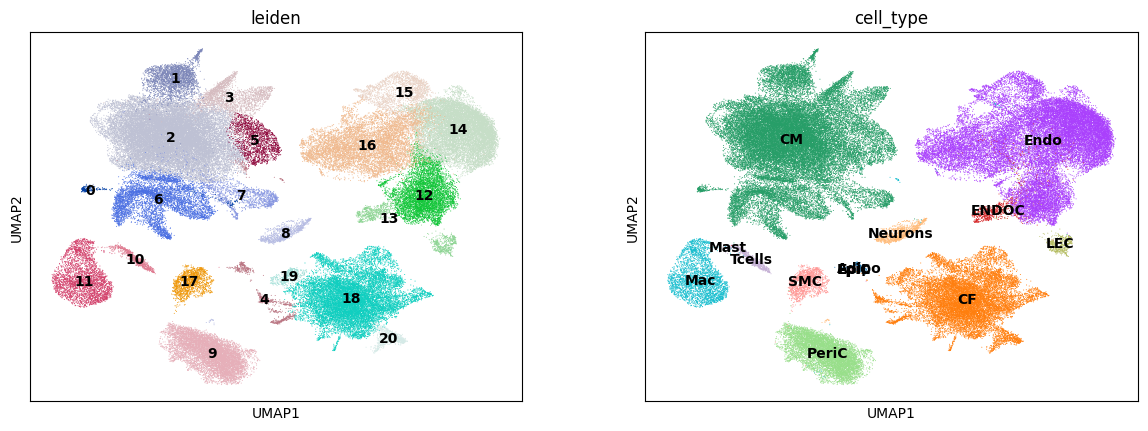

In [17]:
sc.pl.umap(adata, color=["leiden", "cell_type"], size=2, legend_loc = "on data")

### Make cell type annotations consistent

In [18]:
adata.obs["consistent_cell_type"] = adata.obs["cell_type"].map(
    {
        "CM": "Cardiomyocyte",
        "Endo": "Endothelial",
        "CF": "Fibroblast",
        "Mac": "Myeloid",
        "Neurons": "Neuronal",
        "SMC": "vSMC",
        "ENDOC": "Endocardial",
        "Tcells": "Lymphoid",
        "Adipo": "Adipocyte",
        "LEC": "LEC",
        "Mast": "Mast",
        "EpiL": "Endothelial",
        "EpiC": "Epicardial",
        "PeriC": "Pericyte",
    }
)

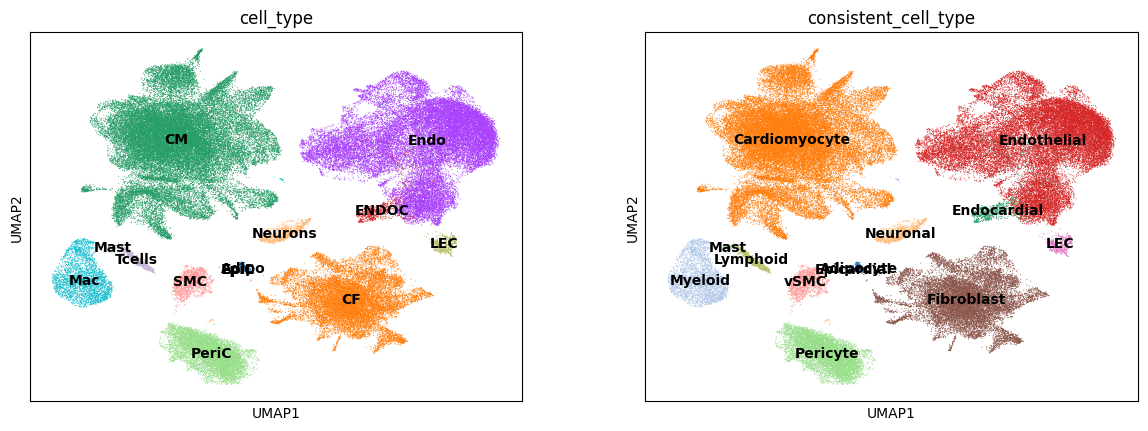

In [19]:
sc.pl.umap(adata, color=["cell_type", "consistent_cell_type"], size=2, legend_loc = "on data")

In [20]:
adata.write("02_processed_Hill_D.h5ad")